In [1]:
import numpy as np
import scipy as sc
from scipy.stats import norm
import time
import pandas as pd
import asyncio
import nest_asyncio
nest_asyncio.apply()
import websockets
import json


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [21]:
S = 76 #asset price
Smin = 0.4 #asset min
Smax = 150 #asset max
K = 8  # strike price
r = 0.1 #interest rate
d = 0 #divident rate
sigma = 0.4 # measure of how much the security prices will move in the subsequent periods
T = 1
t = 0
omega = 1.5
tol = 0.001

X = np.log(S/K)
k = r/(0.5*sigma**2)
kd = (r-d)/(0.5*sigma**2)
M = 200
Nminus =-100
Nplus = 100
N = Nplus - Nminus
u = np.zeros((N+1, M+1))
dt = (0.5*T*sigma**2)/M
Xzero = np.log(Smin/K)
Xmax = np.log(Smax/K)
dX = (Xmax-Xzero)/N
alpha = dt/(dX*dX)
Xmesh = np.array([Xzero + j*dX for j in range(N+1)])
Tmesh = np.array([j*dt for j in range(M+1)])

#payoff matrix
g = np.zeros((N+1,M+1))
for n in range(N+1):
    for m in range(1,M+1):
        g[n,m]=np.exp((0.25*(kd-1)**2+k)*((m)*dt))* \
            (max(float((np.exp(0.5*(kd+1)*(n+Nminus)*dX)-np.exp(0.5*(kd-1)*(n+Nminus)*dX))),0))
    g[n,0]=max(float((np.exp(0.5*(kd+1)*(n+Nminus)*dX)-np.exp(0.5*(kd-1)*(n+Nminus)*dX))),0)
g[0,:]=0

u[:,0]=g[:,0]
u[0,:]=g[0,:]
u[N,:]=g[N,:]

a = -alpha
c = 1+2*alpha


for p in range(M):
    temp = np.zeros((N-1,1))
    temp[0]= a*g[0,p+1]
    temp[-1]= a*g[N,p+1]
    RHS = u[1:N-1,p]-temp
    b = RHS
    x = np.maximum(u[1:N-1,p],g[1:N-1,p+1])
    xold = 1000*X
    n = len(x)

    while np.linalg.norm(xold-x)>tol:
        xold =x
        for i in range(n):
            if i==0:
                z = (b[i,0]+alpha*x[i+1])/c
                x[i] = max(float(omega*z + (1-omega)*xold[i]),float(g[i,p]))
            elif i==n-1:
                z = (b[i,0]+alpha*x[i-1])/c
                x[i] = max(float(omega*z + (1-omega)*xold[i]),float(g[i,p]))
            else:
                z = (b[i,0]+alpha*(x[i+1]+x[i-1]))/c
                x[i] = max(float(omega*z + (1-omega)*xold[i]),float(g[i,p]))
    u[1:-2,p+1]=x

uresult = np.interp(X, Xmesh, u[:,M])

#option value
value = K*K**(0.5*(kd-1))*S**(-0.5*(kd-1))*np.exp((-(0.25)*(kd-1)**2-k)*0.5*sigma**2*T)*uresult
value

7.564317355107215

In [42]:
# Initialise parameters
S0 = 40     # initial stock price
K = 35       # strike price
N = 100         # number of time steps
T = 1         # time to maturity in years
r = 0.2      # annual risk-free rate
u = 1.1       # up-factor in binomial models
d = 1/u       # ensure recombining tree
opttype = 'C' # Option Type 'C' or 'P'        
def american_fast_tree(K,T,S0,r,N,u,d,opttype='P'):
    #precompute values
    dt = T/N
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)
    
    # initialise stock prices at maturity
    S = S0 * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
        
    # option payoff 
    if opttype == 'P':
        C = np.maximum(0, K - S)
    else:
        C = np.maximum(0, S - K)
    
    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        S = S0 * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
        C[:i+1] = disc * ( q*C[1:i+2] + (1-q)*C[0:i+1] )
        C = C[:-1]
        if opttype == 'P':
            C = np.maximum(C, K - S)
        else:
            C = np.maximum(C, S - K)
                
    return C[0]
american_fast_tree(K,T,S0,r,N,u,d,opttype='P')

8.45988876832481

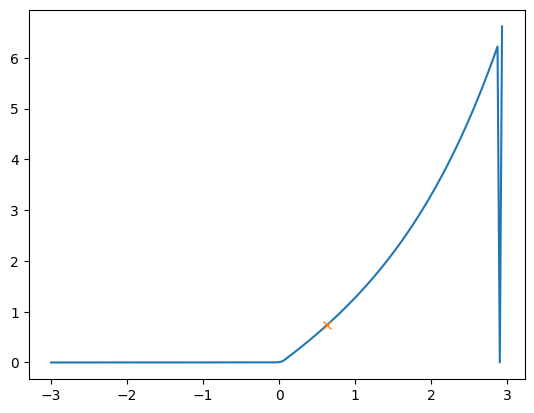

In [54]:
#yinterp = np.interp(xvals, x, y)
yinterp = np.interp(X, Xmesh, u[:,M])
import matplotlib.pyplot as plt
plt.plot(Xmesh, u[:,M], '-')
plt.plot(X, yinterp, '-x')
plt.show()

In [45]:
5*6*3*4*4*6*4*3*2*5*8*9

74649600

In [2]:
series_metadata ={
            'isin': 1,
            'ticker': 2,
            'exchange': 3,
            'source': 4
        }
series_identifier = {**{'type':'ticker_series'}, **series_metadata}
series_metadata

{'isin': 1, 'ticker': 2, 'exchange': 3, 'source': 4}

In [4]:
S = 15 #asset Price
delta_t = 1 # time until expiration in years
r = 0.1*delta_t # interest rate
sigma = .4 # measure of how much the security prices will move in the subsequent periods
K= 8 # strike price 

In [6]:
class Option:
    rate=0.1
    def __init__(self,asset_price,sigma):
        self.asset_price = asset_price
        self.sigma = sigma
        
    def Call(self,K,delta_t):
        self.K = K
        self.delta_t = delta_t
        d_1 = (np.log(self.asset_price/K)+(Option.rate*delta_t+self.sigma**2/2)*delta_t)/(self.sigma*np.sqrt(delta_t))
        d_2 = d_1 - sigma*np.sqrt(delta_t)
        co = self.asset_price*norm.cdf(d_1)-K*np.exp(-Option.rate*delta_t*delta_t)*norm.cdf(d_2)
        return co
    def Put(self,K,delta_t):
        d_1 = (np.log(self.asset_price/K)+(Option.rate*delta_t+self.sigma**2/2)*delta_t)/(self.sigma*np.sqrt(delta_t))
        d_2 = d_1 - sigma*np.sqrt(delta_t)
        po = K*np.exp(-Option.rate*delta_t*delta_t)*norm.cdf(-d_2)-self.asset_price*norm.cdf(-d_1)
        return po
    def create_greeks(self,K,delta_t):
        
        d_1 = (np.log(self.asset_price/K)+(Option.rate*delta_t+self.sigma**2/2)*delta_t)/(self.sigma*np.sqrt(delta_t))
        d_2 = d_1 - sigma*np.sqrt(delta_t)
        self.delta_c = norm.cdf(d_1)
        self.delta_p = norm.cdf(d_1) - 1
        self.gamma = norm.pdf(d_1)/(self.asset_price*self.sigma*np.sqrt(delta_t))
        self.vega = self.asset_price*norm.pdf(d_1)*np.sqrt(delta_t)
        self.theta_c = -self.asset_price*norm.pdf(d_1)*self.sigma/(2*np.sqrt(delta_t)) 
        - Option.rate*delta_t*K*np.exp(-Option.rate*delta_t*delta_t)*norm.cdf(d_2)
        self.theta_p = -self.asset_price*norm.pdf(d_1)*self.sigma/(2*np.sqrt(delta_t)) 
        + Option.rate*self.delta_t*self.K*np.exp(-Option.rate*self.delta_t*self.delta_t)*norm.cdf(-self.d_2)
        self.rho_c = self.delta_t*self.K*np.exp(-Option.rate*self.delta_t*self.delta_t)*norm.cdf(self.d_2)
        self.rho_p = -self.delta_t*self.K*np.exp(-Option.rate*self.delta_t*self.delta_t)*norm.cdf(-self.d_2)
        self.greeks = { 'delta_c' : self.delta_c,
                        'delta_p' : self.delta_p,
                        'gamma' : self.gamma,
                        'vega' : self.vega,
                        'theta_c' : self.theta_c,
                        'theta_p' : self.theta_p,
                        'rho_c' : self.rho_c,
                        'rho_p' : self.rho_p}
        return self.greeks

        




In [7]:
option = Option(15,.4)
option.Call(8,delta_t)

7.816798015940451

In [79]:
option = Option(13,.35)
option.Put(16,delta_t)

3.0051939060960233

In [21]:
option.create_greeks(K,delta_t)

{'delta_c': 0.1869017607063853,
 'delta_p': -0.8130982392936147,
 'gamma': 0.0265872368787308,
 'vega': 7.754610756296483,
 'theta_c': -16.284682588222616,
 'theta_p': -16.284682588222616,
 'rho_c': 1.4752059550042698,
 'rho_p': -7.688278393809735}

In [6]:
def BS_model(S,K,delta_t,option='C',rate=0.05,sigma=.35):
    r = rate*delta_t
    d_1 = (np.log(S/K)+(r+sigma**2/2)*delta_t)/(sigma*np.sqrt(delta_t))
    d_2 = d_1 - sigma*np.sqrt(delta_t)
    if option=='C':
        return S*norm.cdf(d_1)-K*np.exp(-r*delta_t)*norm.cdf(d_2)
    elif option=='P':
        return K*np.exp(-r*delta_t)*norm.cdf(-d_2)-S*norm.cdf(-d_1)
    else:
        print('No valid Option!')
        return -1


In [4]:
# Calculation of what to put into the CDF fucntion 

d_1 = (np.log(S/K)+(r+sigma**2/2)*delta_t)/(sigma*np.sqrt(delta_t))
d_2 = d_1 - sigma*np.sqrt(delta_t)
d_1

-0.8893713792699648

In [5]:
#BS-Call
C = S*norm.cdf(d_1)-K*np.exp(-r*delta_t)*norm.cdf(d_2)
C

0.9877046105872935

In [5]:
#BS-Put
P = K*np.exp(-r*delta_t)*norm.cdf(-d_2)-S*norm.cdf(-d_1)
P

10.949516796355368

In [9]:
BS_model(S,K,delta_t,option='M')

No valid Option!


-1

In [25]:
end=round(time.time()*1000)
start = end - 365*24*60*60*1000

In [36]:
msg_vol = \
{
  "jsonrpc" : "2.0",
  "id" : 833,
  "method" : "public/get_volatility_index_data",
  "params" : {
    "currency" : "BTC",
    "start_timestamp" : start,
    "end_timestamp" : end,
    "resolution" : "43200"
  }
}

In [37]:
msg_index = \
{
  "jsonrpc" : "2.0",
  "id" : 7617,
  "method" : "public/get_funding_rate_history",
  "params" : {
    "instrument_name" : "BTC-PERPETUAL",
    "start_timestamp" : start,
    "end_timestamp" : end
  }
}

In [32]:


def api_connect(msg):
    response = 1
    async def call_api(msg):
        async with websockets.connect('wss://test.deribit.com/ws/api/v2') as websocket:
            await websocket.send(msg)
            while websocket.open:
                response = await websocket.recv()
                return response
            
    response = asyncio.get_event_loop().run_until_complete(call_api(json.dumps(msg)))
    return response

In [2]:
import numpy as np
np.random.seed(42)
for i in range(10):
    
    print(np.random.rand(2))

[0.37454012 0.95071431]
[0.73199394 0.59865848]
[0.15601864 0.15599452]
[0.05808361 0.86617615]
[0.60111501 0.70807258]
[0.02058449 0.96990985]
[0.83244264 0.21233911]
[0.18182497 0.18340451]
[0.30424224 0.52475643]
[0.43194502 0.29122914]


In [33]:
response = api_connect(msg_index)
B = json.loads(response)['result']
B

[{'timestamp': 1670101200000,
  'prev_index_price': 16963.72,
  'interest_8h': -0.0001440758445513704,
  'interest_1h': -8.36946594154554e-05,
  'index_price': 16944.98},
 {'timestamp': 1670104800000,
  'prev_index_price': 16944.98,
  'interest_8h': -0.00016958129253614627,
  'interest_1h': -2.603174497546072e-05,
  'index_price': 16956.77},
 {'timestamp': 1670108400000,
  'prev_index_price': 16956.77,
  'interest_8h': -0.00018041230266247437,
  'interest_1h': -1.094290131505943e-05,
  'index_price': 16911.36},
 {'timestamp': 1670112000000,
  'prev_index_price': 16911.36,
  'interest_8h': -0.00018058963768099198,
  'interest_1h': 0.0,
  'index_price': 16893.01},
 {'timestamp': 1670115600000,
  'prev_index_price': 16893.01,
  'interest_8h': -0.0001804712144923025,
  'interest_1h': 0.0,
  'index_price': 16952.46},
 {'timestamp': 1670119200000,
  'prev_index_price': 16952.46,
  'interest_8h': -0.00017587304920995252,
  'interest_1h': 1.168703752639932e-07,
  'index_price': 16970.31},
 {'t

In [28]:
response = api_connect(msg_vol)
A = json.loads(response)['result']['data']
A

[[1641211200000, 76.35, 81.29, 75.37, 77.6],
 [1641254400000, 77.6, 77.69, 74.73, 76.23],
 [1641297600000, 76.23, 76.6, 71.75, 73.48],
 [1641340800000, 73.2, 73.25, 72.28, 72.74],
 [1641384000000, 72.74, 93.83, 72.44, 91.65],
 [1641427200000, 91.65, 93.62, 90.86, 91.86],
 [1641470400000, 91.86, 95.7, 84.08, 91.01],
 [1641513600000, 91.01, 92.36, 85.51, 90.16],
 [1641556800000, 90.16, 92.66, 85.15, 91.48],
 [1641600000000, 91.48, 91.53, 89.35, 89.46],
 [1641643200000, 89.45, 90.4, 87.11, 87.91],
 [1641686400000, 87.91, 88.3, 85.93, 86.49],
 [1641729600000, 86.49, 89.74, 85.68, 89.64],
 [1641772800000, 89.64, 95.7, 80.5, 80.79],
 [1641816000000, 80.79, 87.14, 80.61, 84.18],
 [1641859200000, 84.18, 86.38, 81.09, 86.15],
 [1641902400000, 86.15, 86.2, 83.13, 83.93],
 [1641945600000, 83.93, 84.75, 74.9, 75.32],
 [1641988800000, 75.27, 76.91, 73.13, 74.04],
 [1642032000000, 74.04, 91.67, 73.24, 91.4],
 [1642075200000, 90.08, 91.66, 89.65, 90.99],
 [1642118400000, 90.99, 91.14, 69.41, 69.93],


In [35]:


df = pd.DataFrame(data=A,columns=['Time','Open','High','low','close'])
df['Time']=df['Time'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x/1000)))
df['Time']=pd.to_datetime(df['Time'])

df

,Time,Open,High,low,close
0,2022-01-03 07:00:00,76.35,81.29,75.37,77.60
1,2022-01-03 19:00:00,77.60,77.69,74.73,76.23
2,2022-01-04 07:00:00,76.23,76.60,71.75,73.48
3,2022-01-04 19:00:00,73.20,73.25,72.28,72.74
4,2022-01-05 07:00:00,72.74,93.83,72.44,91.65
...,...,...,...,...,...
726,2023-01-01 07:00:00,60.53,60.87,60.51,60.70
727,2023-01-01 19:00:00,60.70,60.85,60.03,60.14
728,2023-01-02 07:00:00,60.14,60.86,60.08,60.35
729,2023-01-02 19:00:00,60.35,62.00,60.27,60.65


In [40]:
df_2 =pd.DataFrame(data=B)
df_2['timestamp']=df_2['timestamp'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x/1000)))
df_2['timestamp']=pd.to_datetime(df_2['timestamp'])
df_2.rename(columns={"timestamp": "Time"},inplace=True)
df_2

,Time,prev_index_price,interest_8h,interest_1h,index_price
0,2022-12-03 16:00:00,16963.72,-0.000144,-8.369466e-05,16944.98
1,2022-12-03 17:00:00,16944.98,-0.000170,-2.603174e-05,16956.77
2,2022-12-03 18:00:00,16956.77,-0.000180,-1.094290e-05,16911.36
3,2022-12-03 19:00:00,16911.36,-0.000181,0.000000e+00,16893.01
4,2022-12-03 20:00:00,16893.01,-0.000180,0.000000e+00,16952.46
...,...,...,...,...,...
739,2023-01-03 11:00:00,16658.41,-0.000002,-3.624530e-08,16675.61
740,2023-01-03 12:00:00,16675.61,-0.000001,0.000000e+00,16619.47
741,2023-01-03 13:00:00,16619.47,-0.000001,0.000000e+00,16627.67
742,2023-01-03 14:00:00,16627.67,-0.000001,-1.654130e-10,16641.26


In [48]:
df_com= df_2.merge(df, on='Time',how='left').fillna(method='bfill')
df_com

,Time,prev_index_price,interest_8h,interest_1h,index_price,Open,High,low,close
0,2022-12-03 16:00:00,16963.72,-0.000144,-8.369466e-05,16944.98,92.05,92.05,91.19,91.19
1,2022-12-03 17:00:00,16944.98,-0.000170,-2.603174e-05,16956.77,92.05,92.05,91.19,91.19
2,2022-12-03 18:00:00,16956.77,-0.000180,-1.094290e-05,16911.36,92.05,92.05,91.19,91.19
3,2022-12-03 19:00:00,16911.36,-0.000181,0.000000e+00,16893.01,92.05,92.05,91.19,91.19
4,2022-12-03 20:00:00,16893.01,-0.000180,0.000000e+00,16952.46,91.19,91.19,70.53,70.90
...,...,...,...,...,...,...,...,...,...
739,2023-01-03 11:00:00,16658.41,-0.000002,-3.624530e-08,16675.61,NaN,NaN,NaN,NaN
740,2023-01-03 12:00:00,16675.61,-0.000001,0.000000e+00,16619.47,NaN,NaN,NaN,NaN
741,2023-01-03 13:00:00,16619.47,-0.000001,0.000000e+00,16627.67,NaN,NaN,NaN,NaN
742,2023-01-03 14:00:00,16627.67,-0.000001,-1.654130e-10,16641.26,NaN,NaN,NaN,NaN


In [46]:
df_2

,Time,prev_index_price,interest_8h,interest_1h,index_price
0,2022-12-03 16:00:00,16963.72,-0.000144,-8.369466e-05,16944.98
1,2022-12-03 17:00:00,16944.98,-0.000170,-2.603174e-05,16956.77
2,2022-12-03 18:00:00,16956.77,-0.000180,-1.094290e-05,16911.36
3,2022-12-03 19:00:00,16911.36,-0.000181,0.000000e+00,16893.01
4,2022-12-03 20:00:00,16893.01,-0.000180,0.000000e+00,16952.46
...,...,...,...,...,...
739,2023-01-03 11:00:00,16658.41,-0.000002,-3.624530e-08,16675.61
740,2023-01-03 12:00:00,16675.61,-0.000001,0.000000e+00,16619.47
741,2023-01-03 13:00:00,16619.47,-0.000001,0.000000e+00,16627.67
742,2023-01-03 14:00:00,16627.67,-0.000001,-1.654130e-10,16641.26
